In [366]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import log2, inf
from random import randint

In [367]:
class Node:
    children: dict[str, "Node"]
    parent: ("Node" or None)
    attr: str
    value: any
    X: pd.Series
    Y: pd.Series

    def __init__(self, X=None, Y=None, parent=None, children=[], attr=None, value=None):
        self.children = dict().fromkeys(children)
        self.parent = parent
        self.attr = attr
        self.value = value
        self.X = X
        self.Y = Y

    def get_attrs(self):
        attrs = set()
        if self.attr is not None:
            attrs.add(self.attr)
        node = self
        while node.parent is not None:
            node = node.parent
            if node.attr is not None:
                attrs.add(node.attr)
        return np.array(attrs)

In [368]:
data = pd.read_csv("DATA.csv", sep=';')
X_train, X_test, y_train, y_test = train_test_split(
    data[data.columns.drop(["STUDENT ID", "GRADE"])], data["GRADE"], test_size=0.2)

In [369]:
def is_success(Y):
    return Y > 3


def get_info(T: pd.Series, Y: pd.Series):
    entrophy = 0
    success_freq = len(Y[is_success(Y)])
    failed_freq = len(Y) - success_freq
    if success_freq == 0 or failed_freq == 0:
        return 0
    entrophy -= success_freq / len(Y) * log2(success_freq / len(Y))
    entrophy -= failed_freq / len(Y) * log2(failed_freq / len(Y))
    return entrophy


def get_info_x(T: pd.Series, Y: pd.Series, attr: str):
    entrophy = 0
    unique_values = np.unique(T[attr])
    for value in unique_values:
        T_i = T[T[attr] == value]
        entrophy += len(T_i) / len(T) * get_info(T_i, Y[T[attr] == value])
    return entrophy


def get_split_info(T: pd.Series, Y: pd.Series, attr: str):
    entrophy = 0
    unique_values = np.unique(T[attr])
    for value in unique_values:
        T_i = T[T[attr] == value]
        entrophy -= len(T_i) / len(T) * log2(len(T_i) / len(T))
    return entrophy


def get_gain_ratio(T: np.array, Y: np.array, attr: str):
    split_info = get_split_info(T, Y, attr) + 0.00000000001
    return (get_info(T, Y) - get_info_x(T, Y, attr)) / split_info


def get_attr_with_max_gain_ratio(T, Y, attrs: set[str]):
    max_gain_ratio = -inf
    attr_with_max_gain_ratio = None
    for attr in attrs:
        gain_ratio = get_gain_ratio(T, Y, attr)
        if gain_ratio > max_gain_ratio:
            max_gain_ratio = gain_ratio
            attr_with_max_gain_ratio = attr
    return attr_with_max_gain_ratio

In [370]:
class ClassifierByTree:

    def __init__(self):
        self.root = Node(None, None, None, [], None, None)

    def learn(self, X, Y, attr_set):
        nodes = [self.root]
        self.root.X = X
        self.root.Y = Y
        i = 0
        while i < len(nodes):
            node = nodes[i]
            i += 1
            x = node.X
            y = node.Y
            if len(y) < 2:
                continue
            attrs = attr_set - node.get_attrs()
            result_attr = get_attr_with_max_gain_ratio(x, y, attrs)
            if result_attr is None:
                continue
            node.attr = result_attr
            values = np.unique(x[result_attr])
            for value in values:
                rows_with_value = x[result_attr] == value
                child = Node(x[rows_with_value], y[rows_with_value],
                             node, [], None, value)
                nodes.append(child)
                node.children[value] = child

    def proba(self, sample):
        node = self.root
        while node.attr is not None:
            val = sample[node.attr]
            if val not in node.children.keys():
                break
            node = node.children[val]
        X = node.X
        Y = node.Y
        return len(Y[is_success(Y)]) / len(Y)

    def get_root(self):
        return self.root

In [371]:
attrsCount = int(len(data) ** (1 / 2))
attrSet = set()
for i in range(attrsCount):
    attr = randint(1, 31)
    if attr in attrSet:
        while attr in attrSet:
            attr = randint(1, 31)
    attrSet.add(attr)
attrSet = set([str(attr) for attr in list(attrSet)])

attrSet = set([str(attr) for attr in list(range(1, 31))])

In [372]:
classifier_by_tree = ClassifierByTree()
classifier_by_tree.learn(X_train, y_train, attrSet)

In [373]:
def get_accuracy(tp, fp, tn, fn):
    return (tp + tn) / (tp + fp + tn + fn)


def get_precision(tp, fp):
    return tp / (tp + fp)


def get_recall(tp, fn):
    return tp / (tp + fn)

In [374]:
y_pred = y_test.copy()
rift = 0.5
TP, FP, TN, FN = 0, 0, 0, 0
for index in X_test.index:
    sample = X_test.T[index]
    origin_class = y_test[index]
    pred_class = classifier_by_tree.proba(sample)
    if origin_class > 3 and pred_class >= rift:
        TP += 1
    if origin_class > 3 and pred_class < rift:
        FN += 1
    if origin_class <= 3 and pred_class < rift:
        TN += 1
    if origin_class <= 3 and pred_class >= rift:
        FP += 1
    y_pred[index] = pred_class
accuracy = get_accuracy(TP, FP, TN, FN)
precision = get_precision(TP, FP)
recall = get_recall(TP, FN)
print(
    f'count of samples {len(X_test)}\n\tTrue Positive: {TP}\n\tFalse Negative: {FP}\n\tTrue Negative: {TN}\n\tFalse Negative: {FN}\n')
print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}')

count of samples 29
	True Positive: 9
	False Negative: 7
	True Negative: 9
	False Negative: 4

accuracy: 0.6206896551724138
precision: 0.5625
recall: 0.6923076923076923


In [375]:
ORIG_CLASS, PRED_CLASS = 1, 2
results = []
for index in y_pred.index:
    results.append((
        index,
        y_test[index] > 3,
        y_pred[index]
    ))
results.sort(key=lambda x: (x[PRED_CLASS]), reverse=True)
for i in results:
    print(i)
list_precise = [1]
list_recall = [0]
list_tpr = [0]
list_fpr = [0]
number_p = sum([1 if i[ORIG_CLASS] else 0 for i in results])
number_n = sum([1 if not i[ORIG_CLASS] else 0 for i in results])
print(number_n, number_p)

(86, True, 1.0)
(69, True, 1.0)
(18, False, 1.0)
(55, False, 1.0)
(91, True, 1.0)
(119, False, 1.0)
(132, False, 1.0)
(63, True, 1.0)
(67, False, 1.0)
(56, True, 1.0)
(72, True, 1.0)
(65, False, 1.0)
(6, True, 1.0)
(54, False, 1.0)
(96, True, 0.5882352941176471)
(143, True, 0.5)
(47, False, 0.45)
(89, True, 0.4)
(50, False, 0.16666666666666666)
(121, False, 0.1)
(4, False, 0.0)
(81, False, 0.0)
(2, False, 0.0)
(75, True, 0.0)
(61, True, 0.0)
(41, False, 0.0)
(13, False, 0.0)
(104, False, 0.0)
(78, True, 0.0)
16 13


In [376]:
tp = 0
fp = 0
if results[0][ORIG_CLASS]:
    tp = 1
else:
    fp = 1
for i in range(1, number_p + number_n):
    if results[i][ORIG_CLASS]:
        tp += 1
    else:
        fp += 1
    list_precise.append(tp / (tp + fp))
    list_recall.append(tp / number_p)
    list_tpr.append(tp / number_p)
    list_fpr.append(fp / number_n)
list_precise.append(0)
list_recall.append(1)
list_tpr.append(1)
list_fpr.append(1)
x = np.array(list_recall)
y = np.array(list_precise)
tpr = np.array(list_tpr)
fpr = np.array(list_fpr)

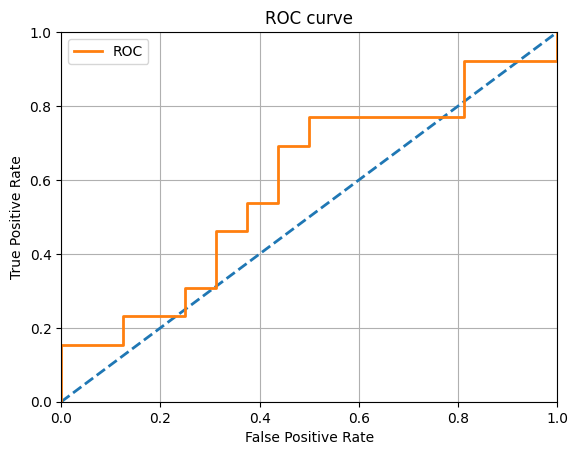

In [377]:
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linewidth=2.0, linestyle="--")
plt.plot(fpr, tpr, label='ROC', linewidth=2.0)
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve")
plt.savefig("auc-roc.png")
plt.show()

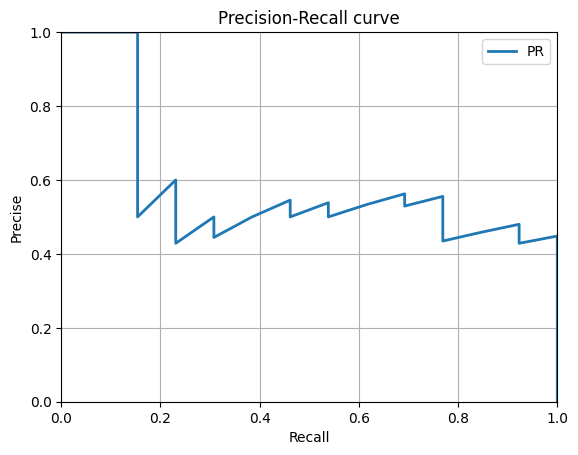

In [378]:
plt.plot(x, y, label='PR', linewidth=2)
plt.grid()
plt.title("Precision-Recall curve")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precise")
plt.savefig("auc-pr.png")
plt.show()